Kaggle Dataset Diabetes, Hypertensionand Stroke Prediction:https://www.kaggle.com/datasets/prosperchuks/health-dataset/data

In [134]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for g in gpus:
    tf.config.experimental.set_memory_growth(g, False)


In [135]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import os
from google.colab import files
from google.colab import drive
import pickle

In [67]:
'''
uploaded = files.upload("diabetes_data.csv")               # click “Choose Files” and select your CSV
uploaded = files.upload("suffled_diabetes_data.csv")
'''             # click “Choose Files” and select your CSV
data_path = "/content/drive/MyDrive/colab_checkpoints/diabetes_data.csv"
shuffled_data_path = "/content/drive/MyDrive/colab_checkpoints/shuffled_diabetes_data.csv"



_drive_mount_path = '/content/drive'
drive.mount(_drive_mount_path)

eval_checkpoint_dir = '/content/drive/MyDrive/colab_checkpoints/model_evaluation_data'
os.makedirs(eval_checkpoint_dir, exist_ok=True)
checkpoint_dir = '/content/drive/MyDrive/colab_checkpoints/overfitting_data'
os.makedirs(checkpoint_dir, exist_ok=True)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
import tensorflow as tf
# List physical devices to confirm GPU is available
print("GPUs available:", tf.config.list_physical_devices('GPU'))
!nvidia-smi                              # shows GPU status and memory


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mon Apr 28 15:49:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P0             30W /   70W |     400MiB /  15360MiB |      0%      Default |
|                                         |              

Used to hopefully boost performance using the T4 GPU in google colab

In [42]:
# 0) (Optional) sanity-check that you have a T4
!nvidia-smi --query-gpu=name,driver_version,uuid --format=csv

# 1) Imports + XLA JIT
import os
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Enable XLA (fuses kernels)
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'
tf.config.optimizer.set_jit(True)

# 2) Enable mixed-precision for Tensor Cores on the T4
mixed_precision.set_global_policy('mixed_float16')
print("Compute dtype:", mixed_precision.global_policy().compute_dtype)
print("Variable dtype:", mixed_precision.global_policy().variable_dtype)


name, driver_version, uuid
Tesla T4, 550.54.15, GPU-84f7ad49-fe2f-53c0-b7a9-c55afb7c23a4
Compute dtype: float16
Variable dtype: float32


Used to shuffle the dataset so that the predictions are not unevely measured.

In [43]:
#Change these paths as needed
data_path = "/content/drive/MyDrive/colab_checkpoints/diabetes_data.csv"
shuffled_data_path =  "/content/drive/MyDrive/colab_checkpoints/shuffled_diabetes_data.csv"

In [44]:
# Load the dataset
df = pd.read_csv(data_path)

#Shuffle the dataframe
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

#Save the shuffled dataframe to a new CSV file
df_shuffled.to_csv(shuffled_data_path, index=False)

# Phase 1

Dataset shape: (70692, 18)
    Age  Sex  HighChol  CholCheck   BMI  Smoker  HeartDiseaseorAttack  \
0  10.0  0.0       1.0        1.0  23.0     1.0                   0.0   
1  13.0  0.0       0.0        1.0  33.0     1.0                   0.0   
2   8.0  1.0       1.0        1.0  27.0     1.0                   0.0   
3   7.0  1.0       1.0        1.0  29.0     1.0                   0.0   
4   6.0  1.0       0.0        1.0  47.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  GenHlth  MentHlth  \
0           1.0     0.0      1.0                0.0      4.0       0.0   
1           0.0     1.0      1.0                0.0      3.0       0.0   
2           1.0     1.0      1.0                0.0      2.0       0.0   
3           0.0     1.0      0.0                0.0      3.0       0.0   
4           1.0     1.0      1.0                0.0      4.0      30.0   

   PhysHlth  DiffWalk  Stroke  HighBP  Diabetes  
0       0.0       0.0     0.0     0.0  

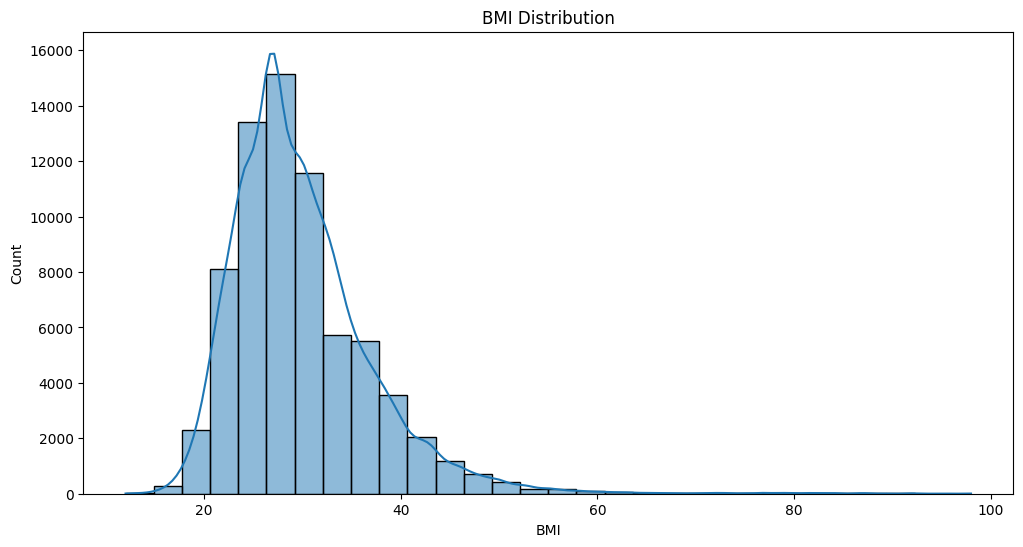

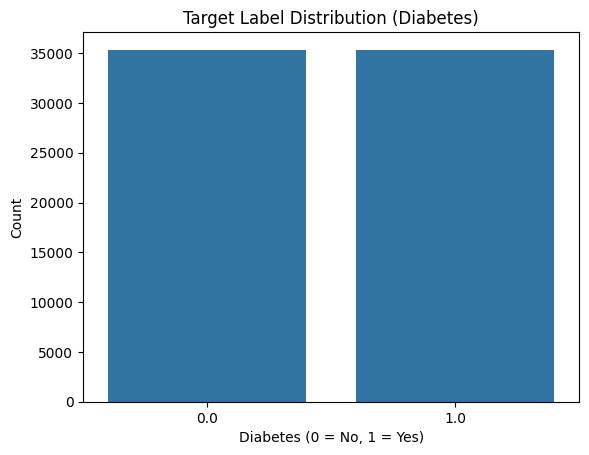

In [45]:

# Display dataset shape and first few rows
print("Dataset shape:", df_shuffled.shape)
print(df_shuffled.head())

# Check for null values
print("\nMissing values:")
print(df_shuffled.isnull().sum())

# Target column: Diabetes (0 or 1)
# Separate features and target
X = df_shuffled.drop(columns=['Diabetes'])
y = df_shuffled['Diabetes']

# Normalize numeric input features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split into training (90%) and validation (10%) sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.1, random_state=42, stratify=y)

# Print resulting shapes
print("\nTraining set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

# Plot feature distribution examples
plt.figure(figsize=(12, 6))
sns.histplot(X['BMI'], kde=True, bins=30)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

sns.countplot(x=y)
plt.title('Target Label Distribution (Diabetes)')
plt.xlabel('Diabetes (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()


# Phase 2

Overfitting the data

In [61]:
# Resume or initialize overfitting results
results_path = os.path.join(checkpoint_dir, 'overfit_results.pkl')
if os.path.exists(results_path):
    with open(results_path, 'rb') as f:
        overfitting_results = pickle.load(f)
else:
    overfitting_results = []
done_configs = {cfg for cfg, *_ in overfitting_results}

In [62]:
# Store results for Phase 2
class EarlyStoppingByAccuracy(Callback):
    def __init__(self, monitor='accuracy', value=0.99):
        super().__init__()
        self.monitor = monitor
        self.value = value
    def on_epoch_end(self, epoch, logs=None):
        if logs.get(self.monitor, 0) >= self.value:
            print(f"Reached {self.value*100:.1f}% training accuracy. Stopping training.")
            self.model.stop_training = True

In [63]:
def build_and_train_overfit_model(hidden_layers, neurons_per_layer, input_dim, epochs, batch_size):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for _ in range(hidden_layers):
        model.add(Dense(neurons_per_layer, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss=BinaryCrossentropy(),
        metrics=['accuracy']
    )
    early_stop = EarlyStoppingByAccuracy(monitor='accuracy', value=0.99)
    history = model.fit(
        X_scaled, y,
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stop]
    )
    final_acc = history.history['accuracy'][-1]
    return model, history, final_acc

In [64]:
epoch_options      = [250]
batch_size_options = [256]
layer_sizes        = [5, 6, 7]
neuron_options     = [256, 512, 1024]

total_start = time.time()

for epochs in epoch_options:
    for batch_size in batch_size_options:
        for layers in layer_sizes:
            for neurons in neuron_options:
                cfg = f"{epochs}e_{batch_size}b_{layers}l_{neurons}n"
                if cfg in done_configs:
                    print(f"✔ Skipping {cfg}, already done.")
                    continue
                print(f"▶ Training model: {cfg}")
                start = time.time()
                model, history, final_acc = build_and_train_overfit_model(
                    hidden_layers=layers,
                    neurons_per_layer=neurons,
                    input_dim=X_scaled.shape[1],
                    epochs=epochs,
                    batch_size=batch_size
                )
                elapsed = time.time() - start
                print(f"Finished model: {cfg} in {elapsed:.2f}s with acc={final_acc:.4f}")
                # Record result
                overfitting_results.append((cfg, final_acc, elapsed))
                done_configs.add(cfg)
                # Persist results
                with open(results_path, 'wb') as f:
                    pickle.dump(overfitting_results, f)
                import pandas as pd
                df = pd.DataFrame(overfitting_results, columns=['config','accuracy','time_s'])
                df.to_csv(os.path.join(checkpoint_dir, 'overfit_results.csv'), index=False)


▶ Training model: 250e_256b_5l_256n
Epoch 1/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7250 - loss: 0.5486
Epoch 2/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7471 - loss: 0.5118
Epoch 3/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7455 - loss: 0.5146
Epoch 4/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7527 - loss: 0.5064
Epoch 5/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7518 - loss: 0.5040
Epoch 6/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7498 - loss: 0.5057
Epoch 7/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7531 - loss: 0.5031
Epoch 8/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7547 - loss: 0.5008
Epoch 9/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7553 - loss: 0.5013
Epoch 10/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7523 - loss: 0.5022
Epoch 11/250
277/277 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7548 - loss: 0.4991
Epoc

In [65]:
total_elapsed = time.time() - total_start
print("\nOverfitting Results:")
for cfg, acc, t in overfitting_results:
    print(f"{cfg} => Training Accuracy: {acc:.4f}, Time: {t:.2f}s")
print(f"\nTotal training time for all models: {total_elapsed:.2f}s")



Overfitting Results:
1e_256b_1l_100n => Training Accuracy: 0.7171, Time: 6.07s
1e_256b_1l_10n => Training Accuracy: 0.6876, Time: 4.70s
250e_256b_5l_256n => Training Accuracy: 0.9154, Time: 279.39s
250e_256b_5l_512n => Training Accuracy: 0.9303, Time: 326.99s
250e_256b_5l_1024n => Training Accuracy: 0.9377, Time: 541.73s
250e_256b_6l_256n => Training Accuracy: 0.9237, Time: 314.27s
250e_256b_6l_512n => Training Accuracy: 0.9262, Time: 378.22s
250e_256b_6l_1024n => Training Accuracy: 0.9365, Time: 580.51s
250e_256b_7l_256n => Training Accuracy: 0.9151, Time: 336.88s
250e_256b_7l_512n => Training Accuracy: 0.9298, Time: 505.91s
250e_256b_7l_1024n => Training Accuracy: 0.9353, Time: 619.04s

Total training time for all models: 3883.23s


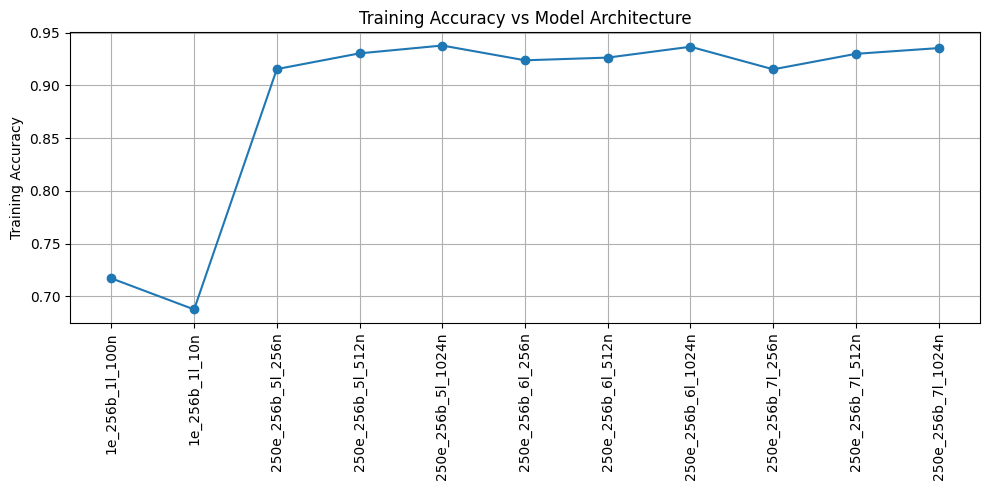

In [66]:
# Plot Accuracy vs Model Configuration
plt.figure(figsize=(10,5))
configs = [cfg for cfg, _, _ in overfitting_results]
accuracies = [acc for _, acc, _ in overfitting_results]
plt.plot(range(len(configs)), accuracies, marker='o')
plt.xticks(range(len(configs)), configs, rotation=90)
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy vs Model Architecture")
plt.grid(True)
plt.tight_layout()
plt.show()

# Phase 3: Model Selection and Evaluation

In [152]:
# Store evaluation results
evaluation_results = []
metrics_csv = os.path.join(eval_checkpoint_dir, 'phase3_metrics.csv')

In [153]:
# Define metric columns
df_columns = [
    'Model','Train_Acc','Train_Loss',
    'Val_Loss','Val_Acc',
    'Precision','Recall','F1_Score','Params','Time_s'
]
# Load existing metrics or initialize empty DataFrame
if os.path.exists(metrics_csv):
    metrics_df = pd.read_csv(metrics_csv)
else:
    metrics_df = pd.DataFrame(columns=df_columns)

#One-time ingestion of existing .keras checkpoints
if metrics_df.empty:
    def ingest_checkpoint(fname):
        model_name = fname.replace('_best.keras','')
        path = os.path.join(eval_checkpoint_dir, fname)
        print(f"Processing existing checkpoint: {model_name}")
        start = time.time()
        model = load_model(path)
        train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        preds = np.round(model.predict(X_val)).flatten()
        precision = precision_score(y_val, preds)
        recall = recall_score(y_val, preds)
        f1 = f1_score(y_val, preds)
        params = model.count_params()
        elapsed = time.time() - start
        metrics_df.loc[len(metrics_df)] = [
            model_name, train_acc, train_loss,
            val_loss, val_acc,
            precision, recall, f1,
            params, elapsed
        ]
    for fname in sorted(os.listdir(eval_checkpoint_dir)):
        if fname.endswith('_best.keras'):
            ingest_checkpoint(fname)
    metrics_df.to_csv(metrics_csv, index=False)
    print(f"Consolidated metrics saved to {metrics_csv}")

In [119]:
# Early stopping callback
class EarlyStoppingByAccuracy(Callback):
    def __init__(self, monitor='accuracy', value=0.99):
        super().__init__()
        self.monitor = monitor
        self.value = value
    def on_epoch_end(self, epoch, logs=None):
        if logs.get(self.monitor, 0) >= self.value:
            print(f"Reached {self.value*100:.1f}% accuracy. Stopping.")
            self.model.stop_training = True

In [120]:
# Training & evaluation function with timing
def train_and_evaluate_model(full_name, layers, units, epochs=250, batch_size=256):
    model = Sequential([Input(shape=(X_train.shape[1],))])
    for _ in range(layers): model.add(Dense(units, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

    ckpt_path = os.path.join(eval_checkpoint_dir, f"{full_name}_best.keras")
    checkpoint = ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, mode='min')
    early_stop = EarlyStoppingByAccuracy()

    print(f"Training model: {full_name}")
    start = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs, batch_size=batch_size,
        callbacks=[checkpoint, early_stop], verbose=1
    )
    elapsed = time.time() - start
    print(f"Finished {full_name} in {elapsed:.1f}s")

    best = load_model(ckpt_path)
    train_loss, train_acc = best.evaluate(X_train, y_train, verbose=0)
    val_loss, val_acc = best.evaluate(X_val, y_val, verbose=0)
    preds = np.round(best.predict(X_val)).flatten()
    precision = precision_score(y_val, preds)
    recall = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    params = best.count_params()
    metrics_df.loc[len(metrics_df)] = [
        full_name, train_acc, train_loss,
        val_loss, val_acc,
        precision, recall, f1,
        params, elapsed
    ]
    metrics_df.to_csv(metrics_csv, index=False)


In [155]:
# 1) Random Baseline
if 'Random Baseline' not in metrics_df['Model'].values:
    random_preds = np.random.choice([0,1], size=y_val.shape)
    metrics_df.loc[len(metrics_df)] = [
        'Random Baseline',
        accuracy_score(y_train, np.random.choice([0,1], size=y_train.shape)),
        1.0,
        1.0, accuracy_score(y_val, random_preds),
        precision_score(y_val, random_preds),
        recall_score(y_val, random_preds),
        f1_score(y_val, random_preds),
        '-', 0.0
    ]
    metrics_df.to_csv(metrics_csv, index=False)

In [122]:
# 2) Logistic Regression
if 'Logistic Regression' not in metrics_df['Model'].values:
    train_and_evaluate_model('Logistic Regression', 0, 1)

In [128]:
# 3. Neural Network Architectures to Evaluate
architectures = {
    '6-6-6-6-6-6-1': [6,6,6,6,6,6],
    '8-8-8-8-8-8-1': [8,8,8,8,8,8],
}
for name, layers in architectures.items():
    if name not in metrics_df['Model'].values:
        train_and_evaluate_model(name, len(layers), layers[0])

In [147]:
# Identify Best Model
best_model = metrics_df.sort_values(by='Val_Acc', ascending=False).iloc[0]
print("\nBest Performing Model:")
print(best_model)


Best Performing Model:
Model         5-5-5-5-5-1
Train_Acc        0.752869
Train_Loss       0.502792
Val_Loss         0.510391
Val_Acc          0.750212
Precision        0.728494
Recall           0.797737
F1_Score         0.761545
Params                216
Time_s           7.857382
Name: 18, dtype: object


Plotting metrics for: ['Random Baseline', 'Logistic Regression', '5-5-5-5-5-1', '5-5-5-5-5-5-1', '6-6-6-6-6-1']


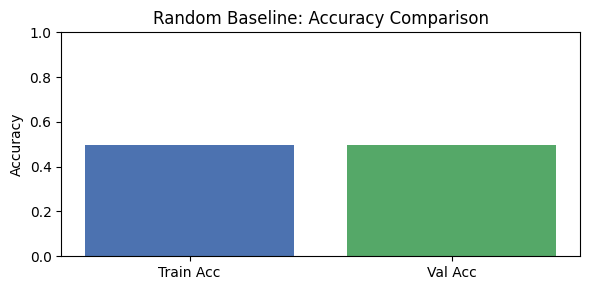

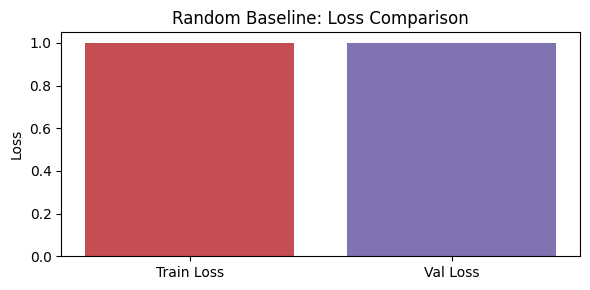

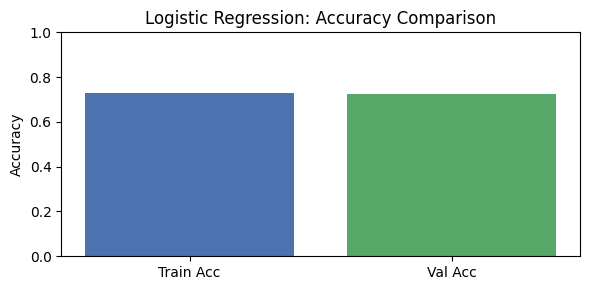

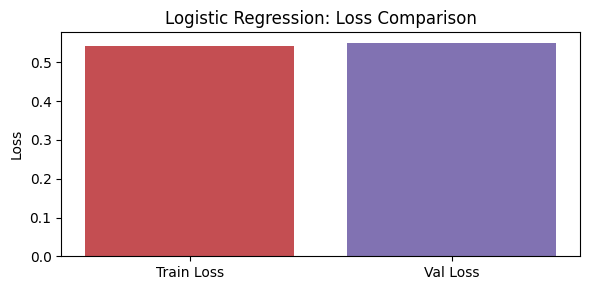

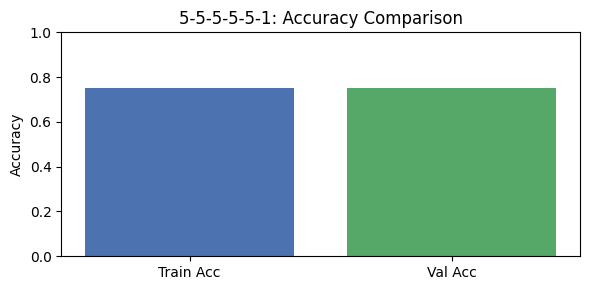

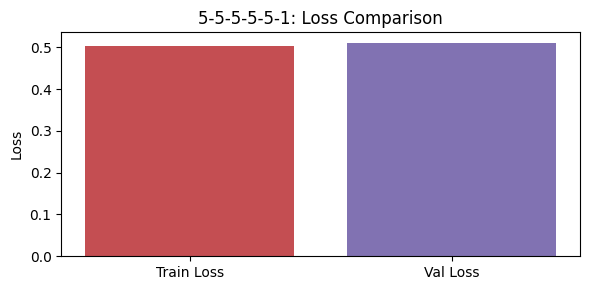

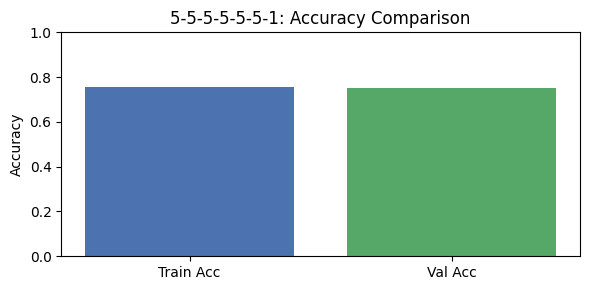

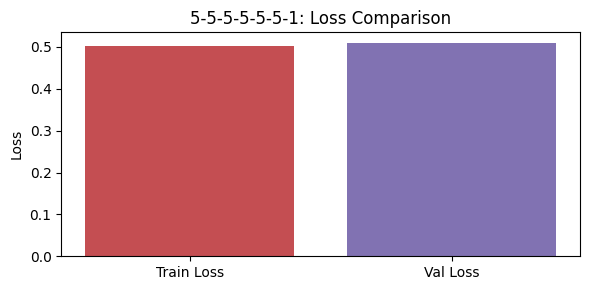

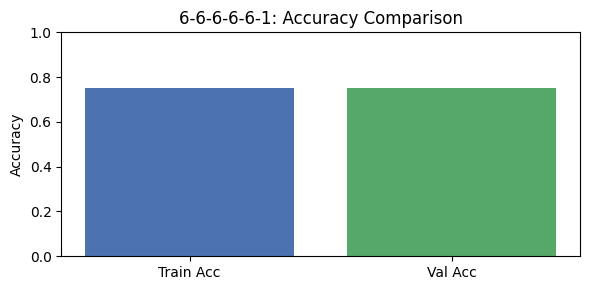

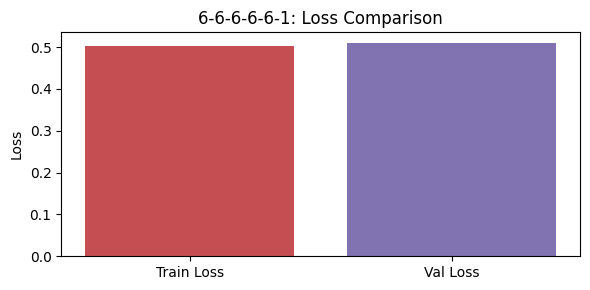

In [161]:
# Load metrics DataFrame from CSV
metrics_df = pd.read_csv(metrics_csv)
# Identify top 3 models by validation accuracy (excluding baseline & logistic)
others = metrics_df[~metrics_df['Model'].isin(['Random Baseline','Logistic Regression'])]
top3 = others.nlargest(3, 'Val_Acc')['Model'].tolist()
# Assemble list to plot: Random Baseline, Logistic Regression, then top 3
plot_models = ['Random Baseline', 'Logistic Regression'] + top3

print("Plotting metrics for:", plot_models)

# For each selected model, plot Train vs Val Accuracy and Loss
for name in plot_models:
    if name not in metrics_df['Model'].values:
        print(f"Model {name} not found in CSV, skipping.")
        continue
    row = metrics_df[metrics_df['Model']==name].iloc[0]
    # Accuracy bar chart
    plt.figure(figsize=(6,3))
    plt.bar(['Train Acc','Val Acc'], [row['Train_Acc'], row['Val_Acc']], color=['#4C72B0','#55A868'])
    plt.title(f"{name}: Accuracy Comparison")
    plt.ylabel('Accuracy')
    plt.ylim(0,1)
    plt.tight_layout()
    plt.show()
    # Loss bar chart
    plt.figure(figsize=(6,3))
    plt.bar(['Train Loss','Val Loss'], [row['Train_Loss'], row['Val_Loss']], color=['#C44E52','#8172B2'])
    plt.title(f"{name}: Loss Comparison")
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()

Best Performing Model:
Model         5-5-5-5-5-1
Train_Acc        0.752869
Train_Loss       0.502792
Val_Loss         0.510391
Val_Acc          0.750212
Precision        0.728494
Recall           0.797737
F1_Score         0.761545
Params                216
Time_s           7.857382
Name: 18, dtype: object


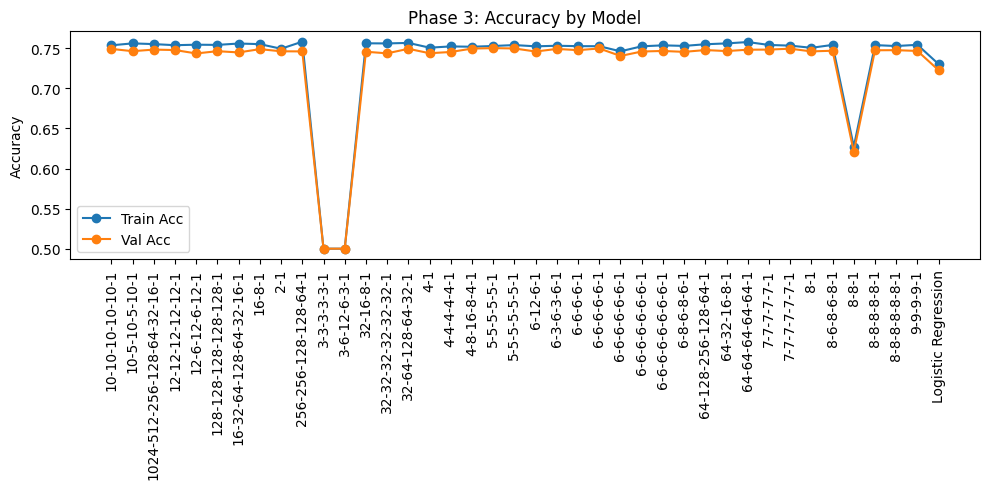

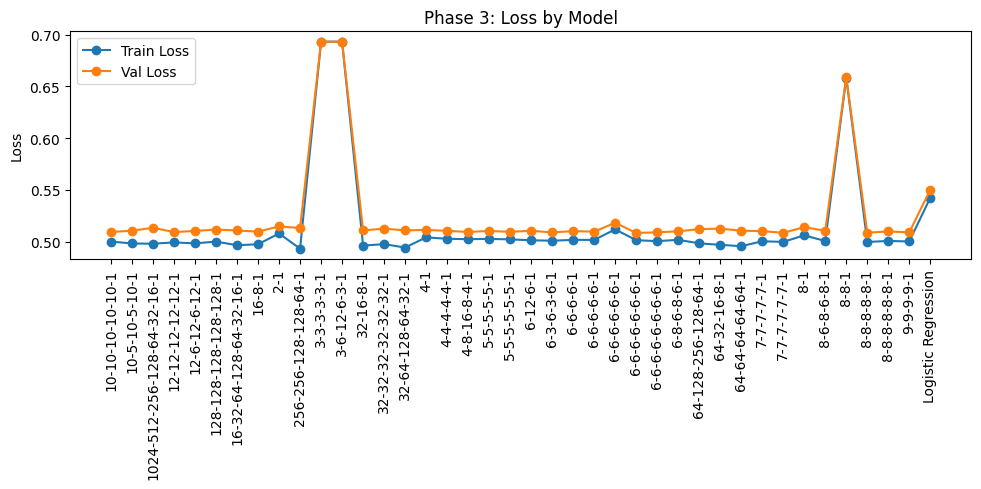

In [142]:
# Identify best model
metrics_df = pd.read_csv(metrics_csv)
best = metrics_df.sort_values('Val_Acc',ascending=False).iloc[0]

# Plot Accuracy across models from CSV
plt.figure(figsize=(10,5))
plt.plot(metrics_df['Model'],metrics_df['Train_Acc'],marker='o',label='Train Acc')
plt.plot(metrics_df['Model'],metrics_df['Val_Acc'],marker='o',label='Val Acc')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Phase 3: Accuracy by Model')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Loss across models from CSV
plt.figure(figsize=(10,5))
plt.plot(metrics_df['Model'],metrics_df['Train_Loss'],marker='o',label='Train Loss')
plt.plot(metrics_df['Model'],metrics_df['Val_Loss'],marker='o',label='Val Loss')
plt.xticks(rotation=90)
plt.ylabel('Loss')
plt.title('Phase 3: Loss by Model')
plt.legend()
plt.tight_layout()
plt.show()

# Phase 4
